<a href="https://colab.research.google.com/github/AyozeGS/IABD/blob/main/M2D/T4/M2D_CLIPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalación y configuración de CLIPS en Google Colab

In [1]:
# Instalar wrapper de clips para python
!pip install clipspy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.6/891.6 kB 6.4 MB/s eta 0:00:00


En este paso se configuran los mensajes de salida de CLIPS para que se muestren en la consola de las celdas de Google Colab.

En primer lugar se configura el módulo logging para mostrar mensajes de depuración y se añade prefijo para saber que los mensajes provienen de CLIPS. Se fuerza la configuración por si hubiera otros manejadores de logging

A continuación se crea un entorno de CLIPS y se instancia un LoggingRouter que se añade a dicho entorno para dirigir los mensajes de este entorno hacia el sistema de logging de Python configurado previamente.

In [2]:
# Importacion de clips
import clips
import logging

# Preparación del entorno
logging.basicConfig(level=logging.DEBUG,
                    force=True,
                    format='CLIPS: %(message)s'
                    )

env = clips.Environment()
router = clips.LoggingRouter()
env.add_router(router)

# Inicializar templates, hechos y reglas

## Templates

Se define un template para indicar los caminos exsitentes en el grafo por el nodo inicial, nodo final, coste y ruta, la cual se tiene un valor por defecto none si no se indica.

Se define un segundo template para indicar el nodo de inicio para calcular los caminos.

Se define un tercer template para indicar una ruta directa a comprobar con su nodo inicial y su nodo final.

Ambos se definen en el entorno creado.

In [3]:
# Templates
templates = [
"""
(deftemplate Distance
	(field Origin)
	(field Destination)
	(field Cost)
  (field Route (default none))
)
""","""
(deftemplate Init_Node
	(field Node)
)
""","""
(deftemplate Check_Route
  (field Origin)
  (field Destination)
)
"""
]

# Definición de templates en el entorno de CLIPS
for template in templates:
   env.build(template)

print("Templates", len(list(env.templates())))

Templates 3


## Hechos

Hay tres grafos a elegir. Debe seleccionarse únicamente el que se vaya a usar o se cargará a CLIPS el último en ejecutarse.

### Grafo 1

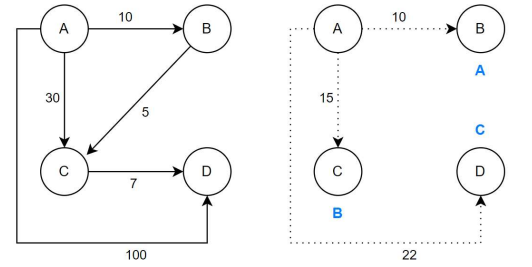

In [ ]:
# Hechos
facts = [
"""
(deffacts Grafo
	(Distance (Origin A)(Destination B)(Cost 10))
	(Distance (Origin A)(Destination C)(Cost 30))
	(Distance (Origin A)(Destination D)(Cost 100))
	(Distance (Origin B)(Destination C)(Cost 5))
	(Distance (Origin C)(Destination D)(Cost 7))
)
"""
]

### Grafo 2

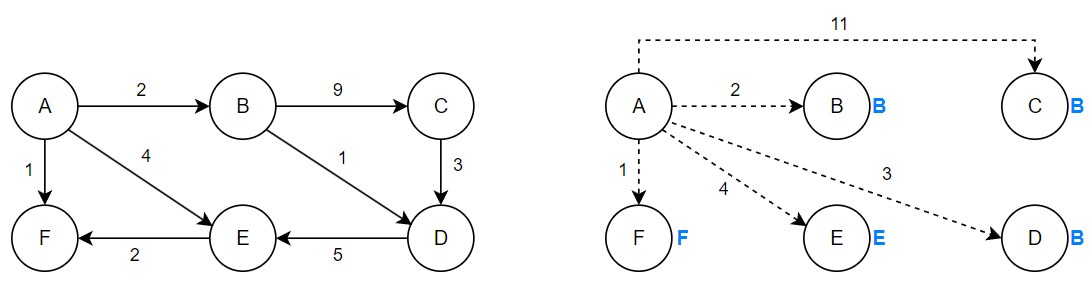

In [4]:
# Hechos
facts = [
"""
(deffacts Grafo
	(Distance (Origin A)(Destination B)(Cost 2))
	(Distance (Origin A)(Destination E)(Cost 4))
	(Distance (Origin A)(Destination F)(Cost 1))
	(Distance (Origin B)(Destination C)(Cost 9))
	(Distance (Origin B)(Destination D)(Cost 1))
	(Distance (Origin C)(Destination D)(Cost 3))
	(Distance (Origin D)(Destination E)(Cost 5))
	(Distance (Origin E)(Destination F)(Cost 2))
)
"""
]

### Grafo 3

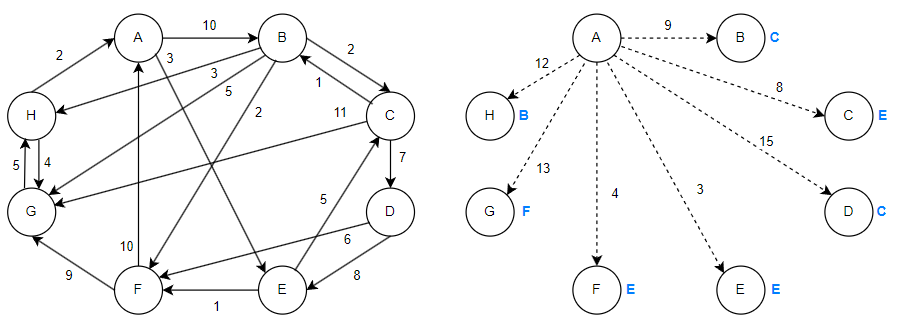

In [5]:
# Hechos
facts = [
"""
(deffacts Grafo
	(Distance (Origin A)(Destination B)(Cost 10))
	(Distance (Origin A)(Destination E)(Cost 3))
	(Distance (Origin B)(Destination C)(Cost 2))
	(Distance (Origin B)(Destination F)(Cost 2))
  (Distance (Origin B)(Destination G)(Cost 5))
	(Distance (Origin B)(Destination H)(Cost 3))
  (Distance (Origin C)(Destination B)(Cost 1))
	(Distance (Origin C)(Destination D)(Cost 7))
  (Distance (Origin C)(Destination G)(Cost 11))
	(Distance (Origin D)(Destination E)(Cost 8))
  (Distance (Origin D)(Destination F)(Cost 6))
	(Distance (Origin E)(Destination C)(Cost 5))
  (Distance (Origin E)(Destination F)(Cost 1))
  (Distance (Origin F)(Destination A)(Cost 10))
  (Distance (Origin F)(Destination G)(Cost 9))
  (Distance (Origin G)(Destination H)(Cost 5))
  (Distance (Origin H)(Destination A)(Cost 2))
  (Distance (Origin H)(Destination G)(Cost 4))
)
"""
]

## Reglas

Se han definido 5 reglas:

* La primera regla con más preferencia inicializa la ruta de cada nodo de la forma (Route ->X) siendo "X" el nombre del nodo destino.
* La segunda regla elimina un camino en el caso de que exista un camino con menor coste.
* La tercera regla crea un camino directo de un nodo A a un nodo B si existe un camino indirecto entre ellos a través de un nodo C sumando el coste de los caminos directos que lo conforman.
* La cuarta regla imprime los caminos mínimos del origen al resto de nodos con la ruta seguida cuando se han creado todos los caminos posibles desde el nodo origen.
* La quinta regla, la menos prioritaria, elimina el nodo inicial cuando se han mostrado todos los caminos.

Todos se añaden al entorno.

In [9]:
#Reglas
rules = []

#Regla para añadir las rutas a los hechos al inicio
rule = """
(defrule Add_route
  (declare (salience 10))
	?Distance <- (Distance (Origin ?node1)(Destination ?node2)(Cost ?Cost)(Route ?Route))
	(test (eq ?Route none))
=>
	(modify ?Distance (Route (str-cat "->" ?node2)))
	;(printout t "Añadida ruta a " ?node1 ">" ?node2 "(" ?Cost ")" crlf)
)
"""
rules.append(rule)


#Regla para eliminar caminos duplicados entre dos nodos con mayor coste.
rule = """
(defrule Find_duplicated
	?DistanceA <- (Distance (Origin ?node1)(Destination ?node2)(Cost ?CostA)(Route ?RouteA))
	?DistanceB <- (Distance (Origin ?node1)(Destination ?node2)(Cost ?CostB)(Route ?RouteB))
	(test (< ?CostA ?CostB))
=>
	(retract ?DistanceB)
	;(printout t "Eliminado " ?node1 ">" ?node2 "(" ?CostB ")" crlf)
)
"""
rules.append(rule)

#Regla para añadir un camino directo a partir de un camino indirecto
rule = """
(defrule Find_indirect_distance
	(Init_Node (Node ?node))
	(test (neq ?node False))
	(Distance (Origin ?node)(Destination ?node1)(Cost ?CostA)(Route ?RouteA))
	(Distance (Origin ?node1)(Destination ?node2)(Cost ?CostB)(Route ?RouteB))
	(test (neq ?node2 ?node))
=>
	(bind ?TotalCost (+ ?CostA ?CostB))
	;(printout t "Encontrado " ?node ">" ?node1 ">" ?node2 "(" ?CostA "+" ?CostB ") -> ")
	(assert (Distance (Origin ?node)(Destination ?node2)(Cost ?TotalCost)(Route (str-cat ?RouteA ?RouteB))))
	;(printout t "Añadido " ?node ">" ?node2 "(" ?TotalCost ")" crlf)
)
"""
rules.append(rule)

#Regla que imprime las rutas finales con los costos a cada nodo desde el nodo inicial
rule = """
(defrule Print_weights
	(declare (salience -10))
	(Init_Node (Node ?node))
	(Distance (Origin ?node)(Destination ?node1)(Cost ?Cost)(Route ?Route))
=>
	(printout t ?node ?Route " (" ?Cost ")" crlf)
)
"""
rules.append(rule)

#Regla que elimina el nodo inicial
rule = """
(defrule Delete_init_node
	(declare (salience -20))
	?init <- (Init_Node (Node ?node))
=>
	(retract ?init)
)
"""
rules.append(rule)

#Regla que imprime la ruta de un nodo origen a un nodo destino
rule = """
(defrule Print_route
	(declare (salience -10))
	(Check_Route (Origin ?origin)(Destination ?destination))
	(Distance (Origin ?origin)(Destination ?destination)(Cost ?Cost)(Route ?Route))
=>
	(printout t ?origin ?Route " con un coste total de " ?Cost "." crlf)
)
"""
rules.append(rule)

#Regla que elimina la ruta a mostrar
rule = """
(defrule Delete_init_route
	(declare (salience -20))
	?init <- (Check_Route (Origin ?origin)(Destination ?destination))
=>
	(retract ?init)
)
"""
rules.append(rule)

# Se añaden los reglas al entorno de CLIPS
for rule in rules:
  env.build(rule)

print("Reglas", len(list(env.rules())))

Reglas 7


# Ejecución en CLIPS

Se definen los hechos y se aplica un RESET para inicializar el entorno de CLIPS.

In [10]:
#Definición de hechos
for fact in facts:
  env.build(fact)

#Inicialización del entorno
env.reset()

print("Hechos", len(list(env.facts())))
display(list(env.facts()))

Hechos 18


[TemplateFact: (Distance (Origin A) (Destination B) (Cost 10) (Route none)),
 TemplateFact: (Distance (Origin A) (Destination E) (Cost 3) (Route none)),
 TemplateFact: (Distance (Origin B) (Destination C) (Cost 2) (Route none)),
 TemplateFact: (Distance (Origin B) (Destination F) (Cost 2) (Route none)),
 TemplateFact: (Distance (Origin B) (Destination G) (Cost 5) (Route none)),
 TemplateFact: (Distance (Origin B) (Destination H) (Cost 3) (Route none)),
 TemplateFact: (Distance (Origin C) (Destination B) (Cost 1) (Route none)),
 TemplateFact: (Distance (Origin C) (Destination D) (Cost 7) (Route none)),
 TemplateFact: (Distance (Origin C) (Destination G) (Cost 11) (Route none)),
 TemplateFact: (Distance (Origin D) (Destination E) (Cost 8) (Route none)),
 TemplateFact: (Distance (Origin D) (Destination F) (Cost 6) (Route none)),
 TemplateFact: (Distance (Origin E) (Destination C) (Cost 5) (Route none)),
 TemplateFact: (Distance (Origin E) (Destination F) (Cost 1) (Route none)),
 TemplateF

Se indica por teclado el nodo inicial para añadir un nuevo hecho con dicho Nodo.

Nota: Es posible añadir más de un nodo inicial separados por comas si se quiere actualizar las rutas mínimas desde dichos nodos al resto.

In [11]:
# Captura el nodo inicial para definir un nuevo hecho
nodes = input("Por favor, introduce el/los nodo/s inicial/es separados por comas: ")
rules_launched = 0
for node in nodes.split(sep=","):
  #Se añade un hecho con un nodo inicial
  env.assert_string(f'(Init_Node (Node {node}))')
  # Se ejecuta el entorno de CLIPS
  rules_launched += env.run()
#print("Se han lazando", rules_launched,"reglas")

Por favor, introduce el/los nodo/s inicial/es separados por comas: A


CLIPS: A->E->F->G (13)
CLIPS: A->E->F (4)
CLIPS: A->E->C->D (15)
CLIPS: A->E->C->B->H (12)
CLIPS: A->E->C->B (9)
CLIPS: A->E->C (8)
CLIPS: A->E (3)


Indica el actual coste de una ruta directa entre un nodo origen y un nodo final.

Nota: Puede mostrarse antes o después de actualizar las rutas mínimas para los nodos seleccionados en la celda anterior

In [12]:
# Captura el nodo inicial para definir un nuevo hecho
nodes = input("Por favor, introduce el nodo inicial y final separados por coma (Ej: A,B): ")
nodes = nodes.split(sep=",")
# Se añade un hecho con una ruta a comprobar
env.assert_string(f'(Check_Route (Origin {nodes[0]})(Destination {nodes[1]}))')

# Se ejecuta el entorno de CLIPS
rules_launched = env.run()
#print("Se han lazando", rules_launched,"reglas")

Por favor, introduce el nodo inicial y final separados por coma (Ej: A,B): A,H


CLIPS: A->E->C->B->H con un coste total de 12.


Permite ver los hechos actuales tras la ejecución de ceirtas reglas.

In [13]:
print("Hechos", len(list(env.facts())))
display(list(env.facts()))

Hechos 23


[TemplateFact: (Distance (Origin A) (Destination E) (Cost 3) (Route "->E")),
 TemplateFact: (Distance (Origin B) (Destination C) (Cost 2) (Route "->C")),
 TemplateFact: (Distance (Origin B) (Destination F) (Cost 2) (Route "->F")),
 TemplateFact: (Distance (Origin B) (Destination G) (Cost 5) (Route "->G")),
 TemplateFact: (Distance (Origin B) (Destination H) (Cost 3) (Route "->H")),
 TemplateFact: (Distance (Origin C) (Destination B) (Cost 1) (Route "->B")),
 TemplateFact: (Distance (Origin C) (Destination D) (Cost 7) (Route "->D")),
 TemplateFact: (Distance (Origin C) (Destination G) (Cost 11) (Route "->G")),
 TemplateFact: (Distance (Origin D) (Destination E) (Cost 8) (Route "->E")),
 TemplateFact: (Distance (Origin D) (Destination F) (Cost 6) (Route "->F")),
 TemplateFact: (Distance (Origin E) (Destination C) (Cost 5) (Route "->C")),
 TemplateFact: (Distance (Origin E) (Destination F) (Cost 1) (Route "->F")),
 TemplateFact: (Distance (Origin F) (Destination A) (Cost 10) (Route "->A")